In [ ]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../cleandata/processed_data.csv')
y = np.log(df['adjusted'] / df['adjusted'].shift(1)).dropna()

df.head()

In [ ]:
print(df.info())
df.describe()

In [ ]:
# převedeme do long formátu
df_long = df[["sentiment_negative", "sentiment_neutral", "sentiment_none", "sentiment_positive"]].melt(var_name='variable', value_name='value')

# vytvoříme countplot
sns.countplot(data=df_long, x='variable', hue='value')
plt.title("Distribuce sentiment proměnných")

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

cols1 = ['adjusted', 'volume', 'vix', 'g_trends', 'bull_bear_spread_surv']
df_norm1 = df[cols1].apply(lambda x: (x - x.mean()) / x.std())
for col in cols1:
    ax.plot(df['date'], df_norm1[col], label=col)
ax.legend()
ax.set_title('Porovnání časových řad (skupina 1)')
ax.set_ylabel('Standardizovaná hodnota')

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

cols2 = ['adjusted', 'sma_20', 'sma_50', 'ema_20', 'basic_volatility', 'atr', 'macd', 'macd_signal', 'bb_up', 'bb_dn', 'obv', 'adx']
df_norm2 = df[cols2].apply(lambda x: (x - x.mean()) / x.std())
for col in cols2:
    ax.plot(df['date'], df_norm2[col], label=col)
ax.legend()
ax.set_title('Porovnání časových řad (skupina 2)')
ax.set_xlabel('Datum')
ax.set_ylabel('Standardizovaná hodnota')

In [ ]:
# distribuce predikovane y + v levels
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

sns.histplot(df["adjusted"],  kde=True, ax=ax[0])
ax[0].set_title("Adjusted")
sns.histplot(y, kde=True, ax=ax[1])
ax[1].set_title("Log return")

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
# ACF
plot_acf(df["adjusted"], ax=ax[0], lags=40)
ax[0].set_title(f"ACF pro adjusted")
# PACF
plot_pacf(df["adjusted"], ax=ax[1], lags=40)
ax[1].set_title(f"PACF pro adjusted")

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
# ACF
plot_acf(y, ax=ax[0], lags=40)
ax[0].set_title(f"ACF pro log_return")
# PACF
plot_pacf(y, ax=ax[1], lags=40)
ax[1].set_title(f"PACF pro log_return")

plt.tight_layout()

In [ ]:
# Korelace features
# ukazuji pouze korelace > 0.5
mask = (df.drop(columns=["date", "adjusted"]).corr().abs() < 0.5)
sns.heatmap(df.drop(columns=["date", "adjusted"]).corr(), mask=mask, cmap="YlOrRd")


In [ ]:
sns.heatmap(df.drop(columns=["date", "adjusted"]).corr(), cmap="YlOrRd")

vix_lag1                     -0.006462
vix_lag2                     -0.002787
sentiment_neutral_lag1        0.022815
sentiment_neutral_lag2        0.025426
sentiment_positive_lag1       0.012948
sentiment_positive_lag2      -0.000947
sentiment_negative_lag1      -0.015808
sentiment_negative_lag2       0.002772
g_trends_lag1                -0.000773
g_trends_lag2                -0.001755
bull_bear_spread_surv_lag1    0.005259
bull_bear_spread_surv_lag2    0.004450
volume_lag1                   0.034331
volume_lag2                   0.037057
sma_20_lag1                  -0.012671
sma_20_lag2                  -0.014951
sma_50_lag1                  -0.012564
sma_50_lag2                  -0.013490
ema_20_lag1                  -0.032238
ema_20_lag2                  -0.032458
basic_volatility_lag1        -0.024357
basic_volatility_lag2        -0.019813
atr_lag1                     -0.028896
atr_lag2                     -0.029737
rsi_lag1                      0.030799
rsi_lag2                 

<Axes: >

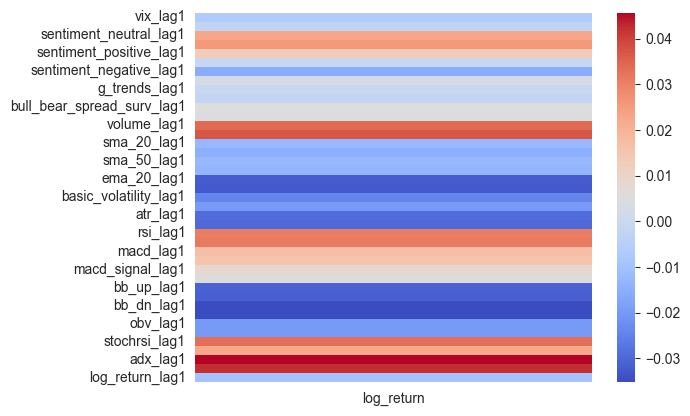

In [7]:
# Korelace kazde x (lag feature) s aktualni y (log return) -> potencialni predikcni sila

# vytvoreni X a y
features = [
    'vix', 'sentiment_neutral', 'sentiment_positive', 'sentiment_negative', 'g_trends',
    'bull_bear_spread_surv', 'volume', 'sma_20',
    'sma_50', 'ema_20', 'basic_volatility', 'atr', 'rsi', 'macd',
    'macd_signal', 'bb_up', 'bb_dn', 'obv', 'stochrsi', 'adx'
]

X = pd.DataFrame()
for col in features:
    X[col + '_lag1'] = df[col].shift(1)
    X[col + '_lag2'] = df[col].shift(2)

# log return
y = np.log(df['adjusted'] / df['adjusted'].shift(1))

X['log_return_lag1'] = y.shift(1)

# Drop 2 prvnich radku kvuli max lag = 2 a zarovnani indexu
X = X.dropna().reset_index(drop=True)
y = y.iloc[2:].reset_index(drop=True)

print(X.corrwith(y))
sns.heatmap(X.corrwith(y).to_frame(name="log_return"), cmap="coolwarm", cbar=True)

In [ ]:
sns.pairplot(df.drop(columns="date"), vars=df.drop(columns="date").columns[:5], height=2)

In [ ]:
sns.pairplot(df.drop(columns="date"), vars=df.drop(columns="date").columns[5:10], height=2)

In [ ]:
sns.pairplot(df.drop(columns="date"), vars=df.drop(columns="date").columns[15:21], height=2)